In [26]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz &> /dev/null
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz &> /dev/null
!cp mystem /bin &> /dev/null

In [28]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords') 
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    classification_report,
    make_scorer
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
import matplotlib.pyplot as plt

In [ ]:
#словарь для кодирования категориальных признаков
topics_dict = {
    'Спорт': 1, 'Мир': 2,
    'Наука и техника': 3, 'Культура': 4,
    'Экономика': 5, 'Интернет и СМИ': 6
}

#дополнение к списку стоп-слов из библиотеки nltk (nltk - 151 слово)
additional_stopwords = ['которых','которые','твой','которой','которого','сих',
                        'ком','свой','твоя','этими','слишком','нами','всему',
                        'будь','саму','чаще','ваше','сами','наш','затем',
                        'самих','наши','ту','каждое','мочь','весь','этим',
                        'наша','своих','оба','который','зато','те','этих','вся',
                        'ваш','такая','теми','ею','которая','нередко','каждая',
                        'также','чему','собой','самими','нем','вами','ими',
                        'откуда','такие','тому','та','очень','сама','нему',
                        'алло','оно','этому','кому','тобой','таки','твоё',
                        'каждые','твои','нею','самим','ваши','ваша','кем','мои',
                        'однако','сразу','свое','ними','всё','неё','тех','хотя',
                        'всем','тобою','тебе','одной','другие','само','эта',
                        'самой','моё','своей','такое','всею','будут','своего',
                        'кого','свои','мог','нам','особенно','её','самому',
                        'наше','кроме','вообще','вон','мною','никто','это']

stop_words = stopwords.words('russian') + additional_stopwords
m = Mystem()

In [ ]:
del_n = re.compile('\n')                # перенос каретки
del_tags = re.compile('<[^>]*>')        # html-теги
del_brackets = re.compile('\([^)]*\)')  # содержимое круглых скобок
clean_text = re.compile('[^а-яa-z\s]')  # все небуквенные символы кроме пробелов
del_spaces = re.compile('\s{2,}')

def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ',res_text)

def del_stopwords(text):
    clean_tokens = tuple(
        map( lambda x: x if x not in stop_words else '', word_tokenize(text) )
    )
    res_text = ' '.join(clean_tokens)
    return res_text

def lemmatize(text):    
    lemmatized_text = ''.join(m.lemmatize(text))
    return lemmatized_text.split('|')

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1hSkbWOlsDDZgSWGxqPPOeGiPxJIquUpO', chunksize = 10000)

In [ ]:
filtered_chunk_list=[]
for chunk in tqdm(df):
    chunk['text'] = chunk['text'].apply(lambda x: prepare_text(str(x)) )
    all_texts = '|'.join( chunk['text'].tolist())
    clean_texts = del_stopwords(all_texts)
    chunk['text'] = lemmatize(clean_texts)

    chunk['title'] = chunk['title'].apply(lambda x: prepare_text(str(x)))
    all_titles = '|'.join( chunk['title'].tolist())
    clean_titles = del_stopwords(all_titles)
    chunk['title'] = lemmatize(clean_titles)

    chunk['topic'] = chunk['topic'].map(topics_dict)
    
    filtered_chunk_list.append(chunk)
model_df = pd.concat(filtered_chunk_list)
model_df.to_csv('text_prepare.csv', index=False) 

In [3]:
df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1KSzMQ-1lS_dlJfngVPpXN8qXlHQ73nih')

In [24]:
df['topic'].value_counts()

2    136621
5     79528
1     64413
4     53797
3     53136
6     44663
Name: topic, dtype: int64

### Представленный ниже код разрабатывался для векторизации текстов с помощью модели Doc2vec. 
### В дальнейшем от данного метода пришлось отказаться в связи со слдеующими проблемами:
- #### длительная обработка
- #### ошибки переполнения памяти
- #### невозможность сохранения результата обучения модели

In [ ]:
def train_vectorizer_model(all_docs):
    tagged_docs = [TaggedDocument( doc.split(' '), [i]) for i, doc in enumerate(all_docs) ]
    model = Doc2Vec(vector_size=512, window=2, min_count=50, workers=8, epochs = 20)
    model.build_vocab(tagged_docs)
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
    return model

# обучение модели Doc2Vec
model = train_vectorizer_model(df['text'].astype(str).tolist())
temp_path = get_tmpfile('vect_model2')
# сохранение модели 
model.save(temp_path)
files.download(temp_path)
# загрузка модели Doc2vec
fname = get_tmpfile('vect_model')
model = Doc2Vec.load(fname)
#векторизация текста с помощью Doc2Vec
df['text'] = df['text'].apply(lambda x: model.infer_vector(x.split(' ')))

- ### В качестве модели классификации была выбрана модель RandomForestClassifier.
- ### Для поиска оптимальных параметров векторизатора TfidfVectorizer и выбранной модели разработан Pipeline  используемый в  HalvingRandomSearchCV.
- ### Так как классификация производится на несбалансированных данных, в качестве метрики выбрал F1-score.

In [4]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_candidates="exhaust",
        factor=5,
        n_jobs=-1,
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [5]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16,10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [6]:
x, y = df['text'].tolist(), df['topic'].tolist()

In [7]:
pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),("base",RandomForestClassifier() )]
)

param_grid = {
    "tfidf__min_df": [i for i in range(25,35,5)],
    "base__n_estimators": [i for i in range(150,250,50)],
    "base__max_depth": [i for i in range(25,35,5)],
    "base__min_samples_split":[i for i in range(6,10,2)],
    "base__min_samples_leaf": [2],
}

estimator = search_best_estimator(pipeline, param_grid, x, y)

### После работы функции search_best_estimator применил найденное значение для классификации

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=42, test_size=0.3, stratify=y
)

estimator.fit(X_train, y_train)
y_preds = estimator.predict(X_test)


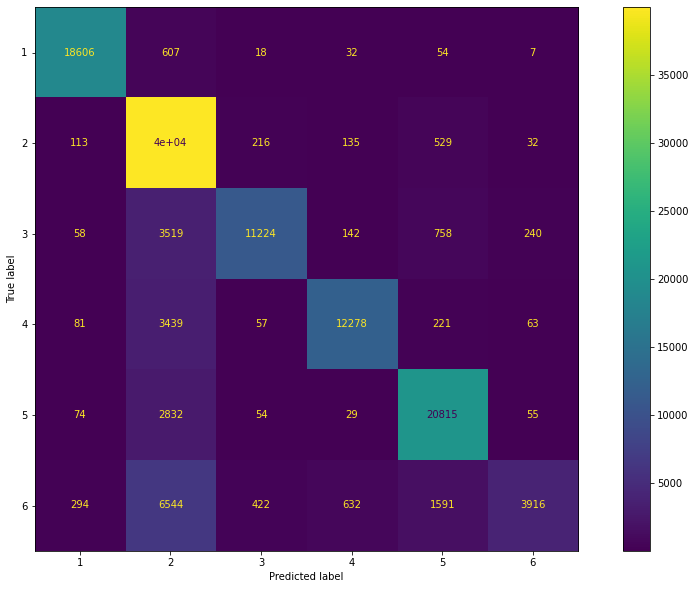

In [9]:
plot_confusion_matrix(y_test, y_preds, estimator)

### Как видно из матрицы путаницы (confusion matrix), наибольшее количество ложных срабатываний приходится на второй класс, который является мажоритарным.
### Точность работы классификатора составляет 69%
### С целью улучшения качества модели решил применить один из методов undersampling, а именно NearMiss

In [7]:
vectorizer = TfidfVectorizer(min_df=30)
vect_x = vectorizer.fit_transform(x)

nm = NearMiss()
X_res, Y_res = nm.fit_resample(vect_x, y)
print('Resampled dataset shape %s' % Counter(Y_res))

Resampled dataset shape Counter({1: 44663, 2: 44663, 3: 44663, 4: 44663, 5: 44663, 6: 44663})


In [11]:
pipeline2 = Pipeline( steps = [("base", RandomForestClassifier() )]  )

param_grid2 = {
        "base__n_estimators": [i for i in range(200,300,50)],
        "base__max_depth": [i for i in range(25,35,5)],
        "base__min_samples_split": [i for i in range(8,12,2)],
}

estimator2 = search_best_estimator(pipeline2, param_grid2, X_res, Y_res)

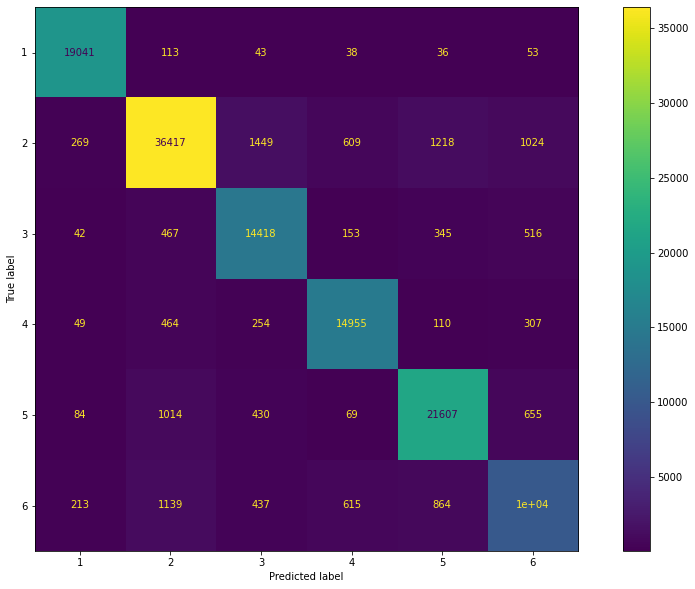

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
estimator2.fit(X_res, Y_res)
y_preds2 = estimator2.predict(X_test)
plot_confusion_matrix(y_test, y_preds2, estimator2)

### Как видно из confusion matrix, проведение undersampling привело к улучшению классификации. Метрика f1-score выросла до 79%

In [29]:
xgbc = XGBClassifier()
xgbc.fit(X_res,[j-1 for j in Y_res])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    vect_x, y, random_state=42, test_size=0.3, stratify=y
)
pred_y = xgbc.predict(X_test)
f1 = f1_score( y_test, [j+1 for j in pred_y], average='weighted')
print( f' Model F1-score: {f1}' )

 Model F1-score: 0.928579374658444


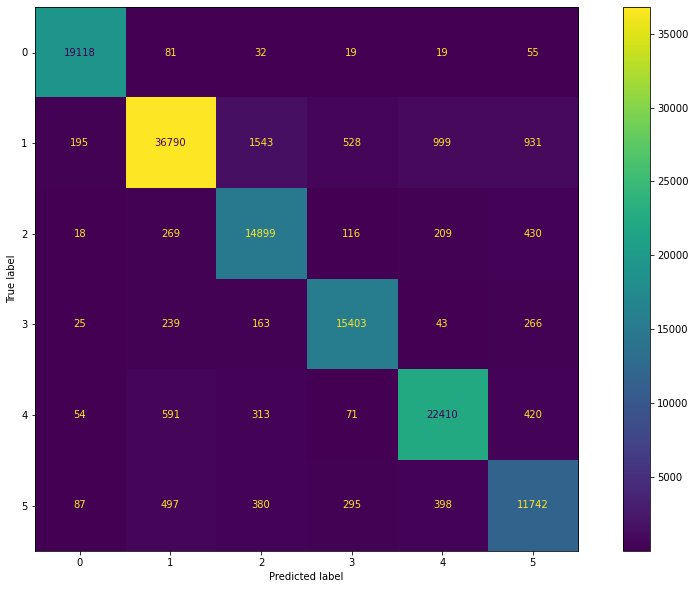

In [32]:
plot_confusion_matrix(y_test2, pred_y, xgbc)

### Взвешенный параметр метрики F1-score для модели XGBoostClassifier достиг 92%.  По confusion matrix заметно, что снизилась доля ошибок при классификации текстов мажоритарного текста.
### На основании полученных результатов, можно сделать вывод, что обучение нужно производить на сбалансированных данных с помощью модели основанной на градиентном бустинге.